In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

import gym
from gym.wrappers import TimeLimit

from irp.envs import TrusEnv, Sahba2008UltraSoundEnv
from irp.callbacks import (
    LogNStepsCallback, EvalCallback, ActionDiversityCallback, LogDissimilarityCallback
)
from irp.wrappers import Discretize, ActionMasker
from irp.q import Q
from irp.mask_q import MaskedQ
from irp import ROOT_DIR, utils

In [4]:
def make_env(x, y, max_unimproved_timesteps, bins, max_timesteps):
    trus_env = Sahba2008UltraSoundEnv(x, y, num_thresholds=15, vjs=(0, 2, 5))
    discr_env = Discretize(trus_env, (0, 0, 0), (1, 1, bins[0] - 1), bins)
    env = TimeLimit(discr_env, max_timesteps)
    # env = ActionMasker(env, action_mask)

    return env

In [5]:
def action_mask(env: TrusEnv = None):
    return env.valid_action_mask()

In [11]:
model_folder = 'masked'
model_id = 'lr=0.8,ef=0.5,er=0.05,g=0.6,mt=100000.0,b=(5, 3, 1),mu=100000.0,mdl=Q_7'

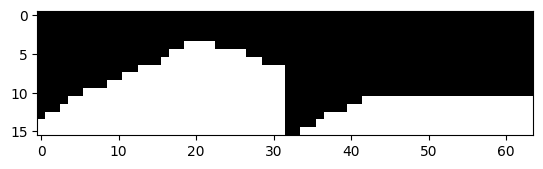

In [12]:
train_path = 'case10_11.png'
test_path = 'case10_12.png'

(train_x, train_y), = utils.make_sample_label(train_path, idx=184)
(test_x, test_y), = utils.make_sample_label(test_path, idx=184)

plt.imshow(np.hstack([train_y, test_y]), cmap='gray', vmin=0, vmax=1)

In [13]:
experiment_env = {
    'max_timesteps': (1e5, 'mt'),
    'bins': ((5, 3, 1), 'b'),
    'max_unimproved_timesteps': (1e5, 'mu')
}

In [14]:
env = make_env(train_x, train_y, **{key: value for key, (value, _) in experiment_env.items()})
eval_env = make_env(test_x, test_y, **{key: value for key, (value, _) in experiment_env.items()})

In [15]:
# Create the path to the model
model_path = f'../irp/results/{model_folder}/model_{model_id}'
# Load the model
model = Q.load(model_path, env)

/home/joel/.pyenv/versions/3.8.0/lib/python3.8/site-packages/torch/cuda/__init__.py:88: UserWarning: HIP initialization: Unexpected error from hipGetDeviceCount(). Did you run some cuda functions before calling NumHipDevices() that might have already set an error? Error 101: hipErrorInvalidDevice (Triggered internally at ../c10/hip/HIPFunctions.cpp:110.)
  return torch._C._cuda_getDeviceCount() > 0


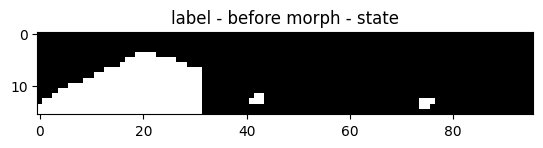

In [21]:
# Reset the environment and show a rendering of it
s = env.reset(); env.render()

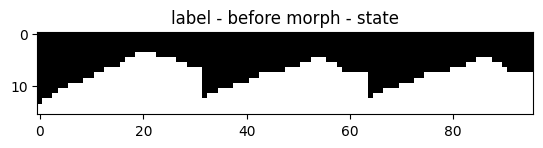

0.056640625


In [39]:
a = model.predict(s, deterministic=True)
sp, r, d, i = env.step(a)
env.render()

print(env.old_dissim)

if d:
    print('Done')
    sp = env.reset()

s = sp

In [220]:
model.policy.q_table[31, 24, 1]

array([-0.49320955,  0.21947255,  1.18931459, -0.53824389, -0.23584432])

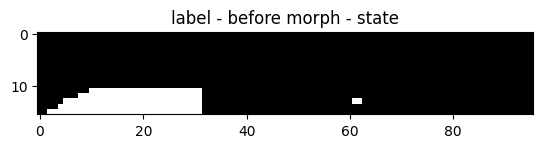

(0.0, 0.0, 0) (0, 0, 0)


In [99]:
# Reset the environment and show a rendering of it
s = eval_env.reset(); eval_env.render()
print(eval_env.state, utils.discrete(eval_env.state, eval_env.env._state_bins))

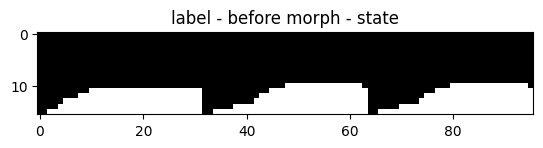

0.0546875


In [113]:
a = model.predict(s, deterministic=True)
sp, r, d, i = eval_env.step(a)
eval_env.render()

print(eval_env.old_dissim)

if d:
    print('Done')
    sp = eval_env.reset()

s = sp

In [83]:
model.policy.q_table[0, 0, 0]

array([0., 0., 0., 0., 0.])